### FSEOF analysis

FSEOF analysis stands for flux scanning based on enforced objective flux. This type of analysis can indicate which reactions can be changed in flux to increase the production of the compound of interest. This is done by enforcing an increasing flux of the objective, here the 7-dehydrocholesterol reaction.

In [8]:
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [9]:
model = read_sbml_model('data/yeastGEM_het.xml')

In [10]:
fseof = FSEOF(model)

In [11]:
fseofresult=fseof.run(target=model.reactions.R07215)

In [12]:
fseofresult

,1,2,3,4,5,6,7,8,9,10
r_0020,0.043157,0.051107,0.059055,0.067003,0.074950,0.082898,0.090846,0.098793,0.106741,0.114689
r_0039,0.043157,0.051107,0.059055,0.067003,0.074950,0.082898,0.090846,0.098793,0.106741,0.114689
r_0040,0.043157,0.051107,0.059055,0.067003,0.074950,0.082898,0.090846,0.098793,0.106741,0.114689
r_0045,0.020012,0.030249,0.040486,0.050723,0.060960,0.071197,0.081434,0.091671,0.101908,0.112145
r_0058,0.020012,0.030249,0.040486,0.050723,0.060960,0.071197,0.081434,0.091671,0.101908,0.112145
...,...,...,...,...,...,...,...,...,...,...
r_4264,0.983103,0.970929,0.981237,0.998792,1.016346,1.033900,1.051454,1.069009,1.086563,1.104117
r_4460,-0.292889,-0.334249,-0.375589,-0.416928,-0.458267,-0.499606,-0.540946,-0.582285,-0.623624,-0.664963
R07498,0.003706,0.007411,0.011117,0.014822,0.018528,0.022233,0.025939,0.029645,0.033350,0.037056
R03353,0.003706,0.007411,0.011117,0.014822,0.018528,0.022233,0.025939,0.029645,0.033350,0.037056


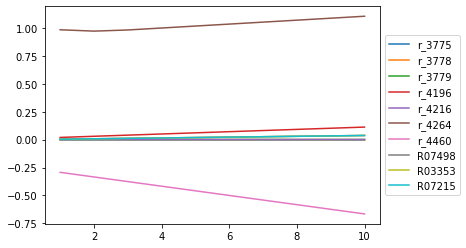

In [18]:
from matplotlib import pyplot as plt
fseofresult.data_frame[148:].T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figures/FSEOF.png")
plt.show()

From the FSEOF analysis, we can see that reaction r_4460 is negative. This suggests that a decrease in this reaction is correlated with an increase in production of 7-dehydrocholesterol. The r_4460 reaction is the phosphate transport via proton symport, which suggests that phosphate limitation might be productive for the optimization of our cell factory. 

We can therefore try to knock out this reaction and see if it changes anything, but we can also try to remove some of the phosphate from the environment.

In [7]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 

Normal growth conditions
Maximal growth rate:
0.08374778664999796
Maximal 7-dehydrocholesterol production rate
0.04117342484804859

Without phosphate
Maximal growth rate:
0.08305465383482832
Maximal 7-dehydrocholesterol production rate
0.040224600029629916


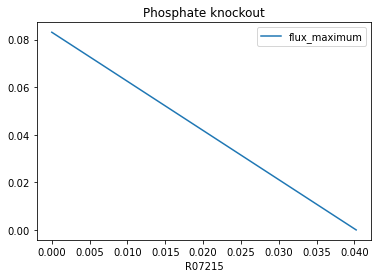

In [8]:
# Phosphate transport knockout
with model:    
    print("Normal growth conditions")
    print("Maximal growth rate:")
    print(model.slim_optimize())
    model.objective = model.reactions.R07215
    print("Maximal 7-dehydrocholesterol production rate")
    print(model.slim_optimize())

with model:
    model.reactions.r_4460.knock_out()
    print("\nWithout phosphate")
    print("Maximal growth rate:")
    print(model.slim_optimize())
    model.objective = model.reactions.R07215
    print("Maximal 7-dehydrocholesterol production rate")
    print(model.slim_optimize())
    ppp_7DH = production_envelope(model,
                    reactions=[model.reactions.R07215],
                    objective=model.reactions.r_2111)
    pppp = ppp_7DH.plot(x='R07215', y='flux_maximum')
    fig = pppp.get_figure()
    plt.title(label="Phosphate knockout")
    fig.savefig("figures/phospate_knockout_ppp")

Normal growth conditions
Maximal growth rate:
0.08374778664999818
Maximal 7-dehydrocholesterol production rate
0.0411734248480483

Without phosphate
Maximal growth rate:
0.0831351110413374
Maximal 7-dehydrocholesterol production rate
0.016666666666666382


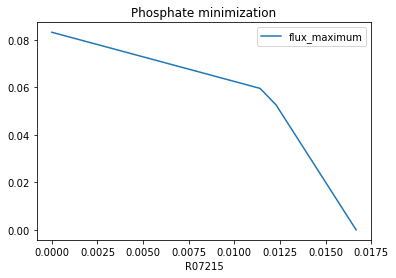

In [9]:
# Phosphate limitation in the media

with model:    
    print("Normal growth conditions")
    print("Maximal growth rate:")
    print(model.slim_optimize())
    model.objective = model.reactions.R07215
    print("Maximal 7-dehydrocholesterol production rate")
    print(model.slim_optimize())

with model:
    medium = model.medium
    medium['r_2005'] = 0.1    
    model.medium = medium
    
    
    print("\nWithout phosphate")
    print("Maximal growth rate:")
    print(model.slim_optimize())
    model.objective = model.reactions.R07215
    print("Maximal 7-dehydrocholesterol production rate")
    print(model.slim_optimize())
    
    ppp_7DH = production_envelope(model,
                    reactions=[model.reactions.R07215],
                    objective=model.reactions.r_2111)
    pppp = ppp_7DH.plot(x='R07215', y='flux_maximum')
    fig = pppp.get_figure()
    plt.title(label="Phosphate minimization")
    fig.savefig("figures/phosphate_minimization_ppp")

From this PPP, we can see our first deviation from the straight line that signals the trade-off between growth and production. We have now a better chance of finding an optimization route. To analyse this further, OptGene can be run under phosphate limitation:

In [4]:
from cameo.strain_design import OptGene

with model:
    medium = model.medium
    medium['r_2005'] =1    
    model.medium = medium
    with model:
        optgene = OptGene(model)
        result_phoslim1 = optgene.run(target=model.reactions.R07215,biomass=model.reactions.r_2111,substrate=model.reactions.r_1714,max_evaluations=2000,plot=False)

Starting optimization at Sun, 29 Nov 2020 21:18:22


HBox()

Finished after 01:09:23


In [5]:
result_phoslim1

,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness


This OptGene analysis did not yield any fruitful results.

Due to the low production under phosphate limitation, this is not further utilised in the project.